In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np 
import cv2
from scipy.signal import find_peaks
from skimage import img_as_float

# Thresholding

In [2]:
def thresh(gray):
    BW = gray > 145
    return BW

# Parametric Segmentation

In [3]:
def Gauss_dist(c,c_s):
    cc = 1/(np.std(c_s)*np.sqrt(2*np.pi))
    cep = -(c-np.mean(c_s))**2/(2*np.std(c_s)**2)
    pc = cc*np.exp(cep)
    
    return pc

# Non-Parametric Segmentation

In [4]:
def Non_parametric(image,patch,hist_sub):  
    hsv = cv2.cvtColor(patch,cv2.COLOR_BGR2HSV)
    hsvt = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    roihist = cv2.calcHist([hsv],[0, 1], None, [180, 256], [0, 180, 0, 256] )
    cv2.normalize(roihist,roihist,0,255,cv2.NORM_MINMAX)
    dst = cv2.calcBackProject([image],[0,1],hist_sub,[0,180,0,256],1)
    # Now convolute with circular disc
    dst = cv2.calcBackProject([hsvt],[0,1],roihist,[0,180,0,256],1)
    disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    cv2.filter2D(dst,-1,disc,dst)
    # threshold and binary AND
    ret,thresh = cv2.threshold(dst,50,255,0)
    thresh = cv2.merge((thresh,thresh,thresh))
    res = cv2.bitwise_and(image,thresh)
    return res

# Original Image

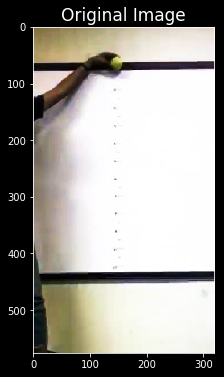

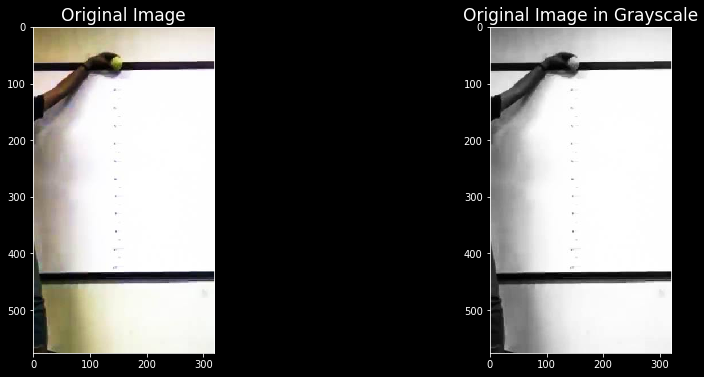

In [5]:
M = cv2.cvtColor(cv2.imread('oop.jpg'), cv2.COLOR_BGR2RGB)
M_sub = cv2.cvtColor(cv2.imread('green_5.png'), cv2.COLOR_BGR2RGB)

R,G,B = cv2.split(M)

M_gray = cv2.cvtColor(M, cv2.COLOR_RGB2GRAY)

plt.style.use('dark_background')
plt.figure(figsize=[15,6])
plt.rcParams['axes.titlesize'] = 17
plt.imshow(M)
plt.title('Original Image')
plt.show()

plt.figure(figsize=[15,6])
plt.rcParams['axes.titlesize'] = 17
plt.subplot(121)
plt.imshow(M)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(M_gray,'gray')
plt.title('Original Image in Grayscale')
plt.show()

# Image Histogram

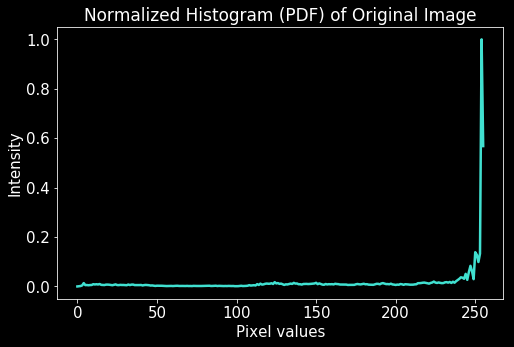

[254]


In [6]:
hist, bin_edges = np.histogram(M_gray, bins = np.linspace(0,255,257), density = "True")
norm_hist = (hist-min(hist))/(max(hist)-min(hist))

peak, _ = find_peaks(norm_hist,height=0.8)

plt.figure(figsize=[8,5])
plt.rcParams['axes.titlesize'] = 17
plt.rcParams.update({'font.size': 15})
plt.plot(norm_hist,'turquoise',linewidth=2.5)
#plt.plot(peak, norm_hist[peak],'x',  color='r', markersize = 10, linewidth=6,label='Peak value')
#plt.text(peak, norm_hist[peak],peak,ha='left', va='top')
#plt.legend()
plt.xlabel('Pixel values')
plt.ylabel('Intensity')
plt.title('Normalized Histogram (PDF) of Original Image')
plt.show()

print(peak)


# Thresholding

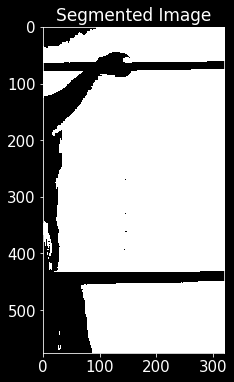

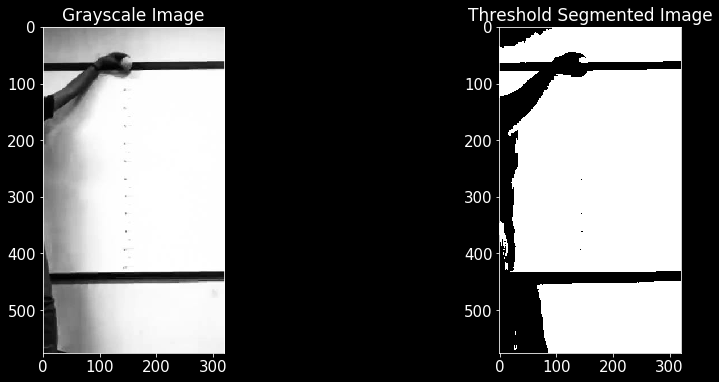

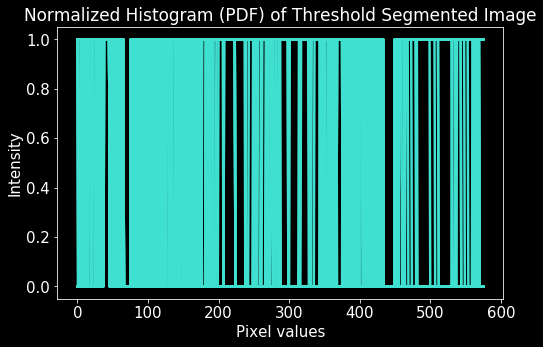

In [7]:
T = thresh(M_gray)

plt.style.use('dark_background')
plt.figure(figsize=[15,6])
plt.rcParams['axes.titlesize'] = 17
plt.imshow(T,'gray')
plt.title('Segmented Image')
plt.show()

plt.figure(figsize=[15,6])
plt.rcParams['axes.titlesize'] = 17
plt.subplot(121)
plt.imshow(M_gray,'gray')
plt.title('Grayscale Image')
plt.subplot(122)
plt.imshow(T,'gray')
plt.title('Threshold Segmented Image')
plt.show()

plt.figure(figsize=[8,5])
plt.rcParams['axes.titlesize'] = 17
plt.rcParams.update({'font.size': 15})
plt.plot(T,'turquoise',linewidth=2.5)
plt.xlabel('Pixel values')
plt.ylabel('Intensity')
plt.title('Normalized Histogram (PDF) of Threshold Segmented Image')
plt.show()


# NCC

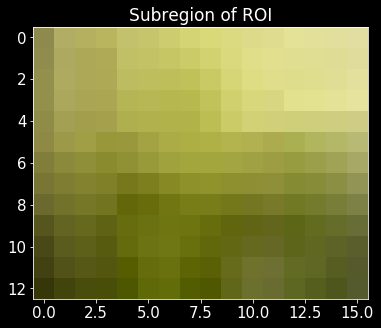

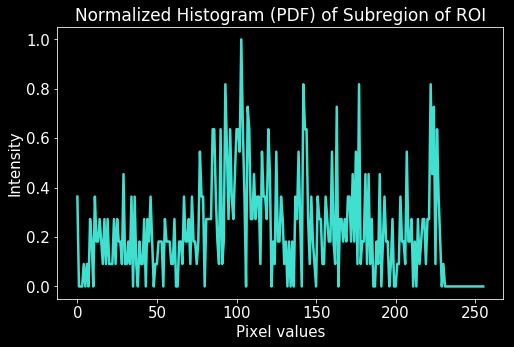

In [8]:
hist_sub, bin_edges_sub = np.histogram(M_sub, bins = np.linspace(0,255,257), density = "True")
norm_hist_sub = (hist_sub-min(hist_sub))/(max(hist_sub)-min(hist_sub))

M_f = img_as_float(M) 
R,G,B = cv2.split(M_f)

# Overall pixels
I = R + G + B
r = R/I
g = G/I
b = 1-r-g

# subregion
M_f_sub = img_as_float(M_sub) 
R1,G1,B1 = cv2.split(M_f_sub)

I_s = R1 + G1 + B1
r_s = R1/I_s
g_s = G1/I_s
b_s = 1-r_s-g_s

plt.style.use('dark_background')
plt.figure(figsize=[12,5])
plt.rcParams['axes.titlesize'] = 17
plt.imshow(M_sub)
plt.title('Subregion of ROI')
plt.show()

plt.figure(figsize=[8,5])
plt.rcParams['axes.titlesize'] = 17
plt.rcParams.update({'font.size': 15})
plt.plot(norm_hist_sub,'turquoise',linewidth=2.5)
plt.xlabel('Pixel values')
plt.ylabel('Intensity')
plt.title('Normalized Histogram (PDF) of Subregion of ROI')
plt.show()


# Parametric Segmentation

In [9]:
  #try to segment a colorful object! see what works better: parametric or nonparametric

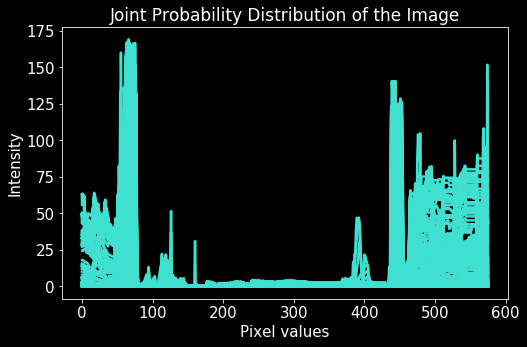

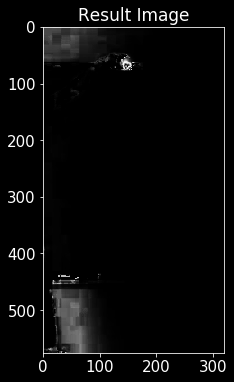

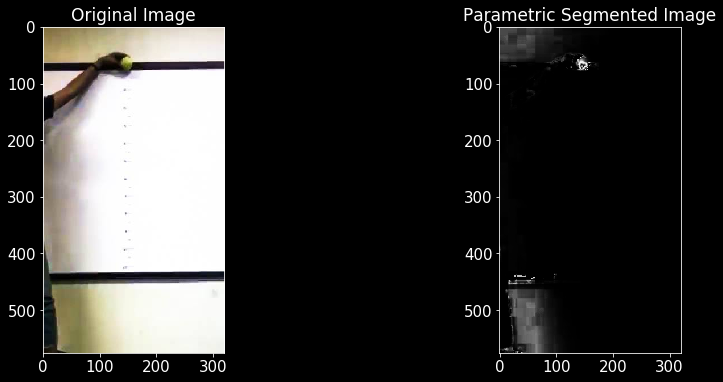

In [10]:
pr = Gauss_dist(r,r_s)
pg = Gauss_dist(g,g_s)
joint = pr*pg

plt.figure(figsize=[8,5])
plt.rcParams['axes.titlesize'] = 17
plt.rcParams.update({'font.size': 15})
plt.plot(joint,'turquoise',linewidth=2.5)
plt.xlabel('Pixel values')
plt.ylabel('Intensity')
plt.title('Joint Probability Distribution of the Image')
plt.show()

plt.style.use('dark_background')
plt.figure(figsize=[15,6])
plt.rcParams['axes.titlesize'] = 17
plt.imshow(joint,'gray')
plt.title('Result Image')
plt.show()

plt.figure(figsize=[15,6])
plt.rcParams['axes.titlesize'] = 17
plt.subplot(121)
plt.imshow(M,'gray')
plt.title('Original Image')
plt.subplot(122)
plt.imshow(joint,'gray')
plt.title('Parametric Segmented Image')
plt.show()

# Non-Parametric Segmentation

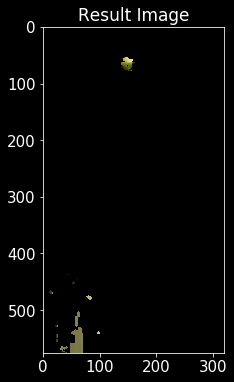

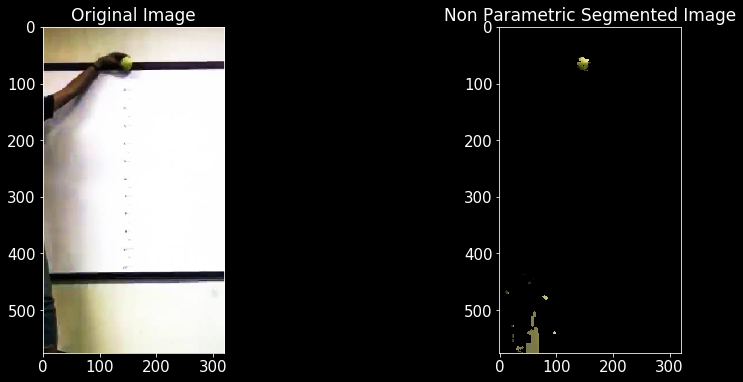

In [11]:
X = Non_parametric(M,M_sub,norm_hist_sub)  

plt.style.use('dark_background')
plt.figure(figsize=[15,6])
plt.rcParams['axes.titlesize'] = 17
plt.imshow(X,'gray')
plt.title('Result Image')
plt.show()

plt.figure(figsize=[15,6])
plt.rcParams['axes.titlesize'] = 17
plt.subplot(121)
plt.imshow(M,'gray')
plt.title('Original Image')
plt.subplot(122)
plt.imshow(X,'gray')
plt.title('Non Parametric Segmented Image')
plt.show()


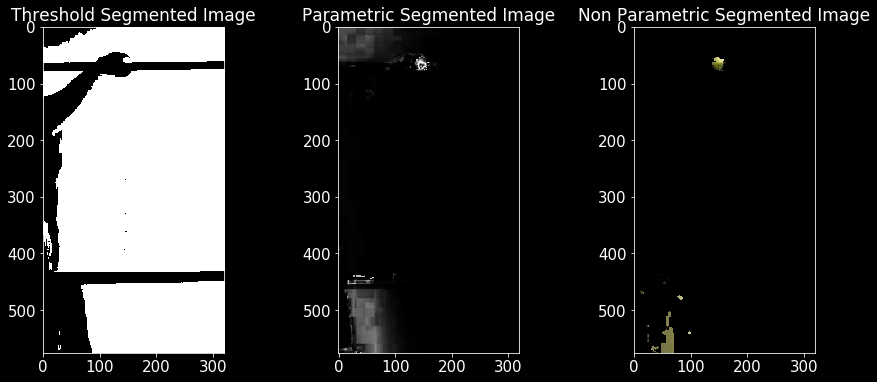

In [12]:
plt.figure(figsize=[15,6])
plt.rcParams['axes.titlesize'] = 17
plt.subplot(131)
plt.imshow(T,'gray')
plt.title('Threshold Segmented Image')
plt.subplot(132)
plt.imshow(joint,'gray')
plt.title('Parametric Segmented Image')
plt.subplot(133)
plt.imshow(X,'gray')
plt.title('Non Parametric Segmented Image')
plt.show()
